In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from catboost import CatBoostRegressor
import joblib

In [7]:
path = "./FE_hourly.csv"

In [8]:
df = pd.read_csv(path, index_col='Datetime', parse_dates=True)

In [9]:
df.head()

,FE_MW
Datetime,
2011-12-31 01:00:00,6222.0
2011-12-31 02:00:00,5973.0
2011-12-31 03:00:00,5778.0
2011-12-31 04:00:00,5707.0
2011-12-31 05:00:00,5691.0


In [10]:
df = df.rename(columns={"FE_MW": "y"})

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62874 entries, 2011-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       62874 non-null  float64
dtypes: float64(1)
memory usage: 982.4 KB


In [12]:
df.index

DatetimeIndex(['2011-12-31 01:00:00', '2011-12-31 02:00:00',
               '2011-12-31 03:00:00', '2011-12-31 04:00:00',
               '2011-12-31 05:00:00', '2011-12-31 06:00:00',
               '2011-12-31 07:00:00', '2011-12-31 08:00:00',
               '2011-12-31 09:00:00', '2011-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=62874, freq=None)

In [13]:
df = df.groupby(df.index).mean()

In [14]:
df = df.asfreq('h')

In [15]:
df.head(10)

,y
Datetime,
2011-06-01 01:00:00,0.0
2011-06-01 02:00:00,8548.0
2011-06-01 03:00:00,8121.0
2011-06-01 04:00:00,7801.0
2011-06-01 05:00:00,7729.0
2011-06-01 06:00:00,7968.0
2011-06-01 07:00:00,8363.0
2011-06-01 08:00:00,9079.0
2011-06-01 09:00:00,9785.0


In [16]:
df.isnull().sum()

y    10
dtype: int64

In [17]:
df['y'] = df['y'].ffill()

In [18]:
df.isnull().sum()

y    0
dtype: int64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62880 entries, 2011-06-01 01:00:00 to 2018-08-03 00:00:00
Freq: h
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       62880 non-null  float64
dtypes: float64(1)
memory usage: 982.5 KB


In [20]:
df.describe()

,y
count,62880.000000
mean,7792.061212
std,1331.235151
min,0.000000
25%,6806.750000
50%,7700.000000
75%,8556.000000
max,14032.000000


## Feature Engineering

In [21]:
# Lag feature in 1h, 2h, 3h, 1day, 2days, 1week
for lag in [1, 2, 3, 24, 48, 168]:
    df[f"lag_{lag}h"] = df['y'].shift(lag)

In [22]:
# 1 day rolling
df['rolling_mean_24h'] = df['y'].rolling(window=24).mean()
# 1 week
df['rolling_mean_168h'] = df['y'].rolling(window=168).mean()

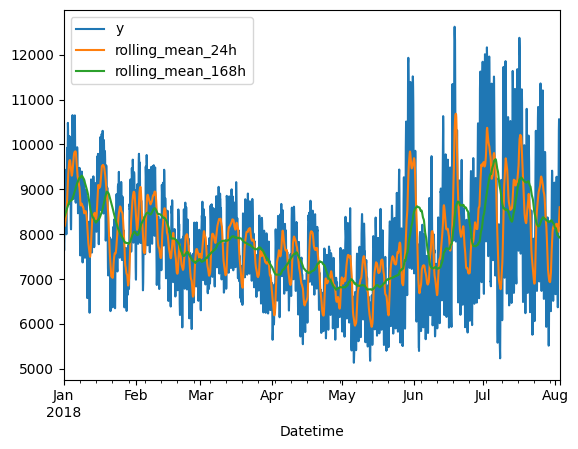

In [23]:
df[['y', 'rolling_mean_24h', 'rolling_mean_168h']].loc['2018'].plot()
plt.show()

In [24]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour
# df['weekday'] = df.index.day_name()
df['weekday_numeric'] = df.index.weekday
df['is_weekend'] = df.index.weekday > 4
df['is_peak_hour'] = ((df.index.hour > 8 )& (df.index.hour < 22)).astype(int)

In [25]:
# Cyclical encoding
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

In [26]:
df.tail(10)

,y,lag_1h,lag_2h,lag_3h,lag_24h,lag_48h,lag_168h,rolling_mean_24h,rolling_mean_168h,year,month,day,hour,weekday_numeric,is_weekend,is_peak_hour,hour_sin,hour_cos,month_sin,month_cos
Datetime,,,,,,,,,,,,,,,,,,,,
2018-08-02 15:00:00,10322.0,10079.0,9639.0,9242.0,9264.0,9016.0,10950.0,8185.333333,7938.113095,2018,8,2,15,3,False,1,-0.707107,-7.071068e-01,-0.866025,-0.5
2018-08-02 16:00:00,10489.0,10322.0,10079.0,9639.0,9280.0,9039.0,11162.0,8235.708333,7934.107143,2018,8,2,16,3,False,1,-0.866025,-5.000000e-01,-0.866025,-0.5
2018-08-02 17:00:00,10564.0,10489.0,10322.0,10079.0,9240.0,9148.0,11204.0,8290.875000,7930.297619,2018,8,2,17,3,False,1,-0.965926,-2.588190e-01,-0.866025,-0.5
2018-08-02 18:00:00,10458.0,10564.0,10489.0,10322.0,9098.0,9134.0,11040.0,8347.541667,7926.833333,2018,8,2,18,3,False,1,-1.000000,-1.836970e-16,-0.866025,-0.5
2018-08-02 19:00:00,10158.0,10458.0,10564.0,10489.0,8927.0,8997.0,10559.0,8398.833333,7924.446429,2018,8,2,19,3,False,1,-0.965926,2.588190e-01,-0.866025,-0.5
2018-08-02 20:00:00,9866.0,10158.0,10458.0,10564.0,8682.0,8871.0,10028.0,8448.166667,7923.482143,2018,8,2,20,3,False,1,-0.866025,5.000000e-01,-0.866025,-0.5
2018-08-02 21:00:00,9656.0,9866.0,10158.0,10458.0,8570.0,8900.0,9595.0,8493.416667,7923.845238,2018,8,2,21,3,False,1,-0.707107,7.071068e-01,-0.866025,-0.5
2018-08-02 22:00:00,9532.0,9656.0,9866.0,10158.0,8555.0,8785.0,9221.0,8534.125000,7925.696429,2018,8,2,22,3,False,0,-0.500000,8.660254e-01,-0.866025,-0.5
2018-08-02 23:00:00,8872.0,9532.0,9656.0,9866.0,8017.0,8318.0,8528.0,8569.750000,7927.744048,2018,8,2,23,3,False,0,-0.258819,9.659258e-01,-0.866025,-0.5


In [27]:
df.isnull().sum()

y                      0
lag_1h                 1
lag_2h                 2
lag_3h                 3
lag_24h               24
lag_48h               48
lag_168h             168
rolling_mean_24h      23
rolling_mean_168h    167
year                   0
month                  0
day                    0
hour                   0
weekday_numeric        0
is_weekend             0
is_peak_hour           0
hour_sin               0
hour_cos               0
month_sin              0
month_cos              0
dtype: int64

In [28]:
df = df.dropna()

In [29]:
df.isnull().sum()

y                    0
lag_1h               0
lag_2h               0
lag_3h               0
lag_24h              0
lag_48h              0
lag_168h             0
rolling_mean_24h     0
rolling_mean_168h    0
year                 0
month                0
day                  0
hour                 0
weekday_numeric      0
is_weekend           0
is_peak_hour         0
hour_sin             0
hour_cos             0
month_sin            0
month_cos            0
dtype: int64

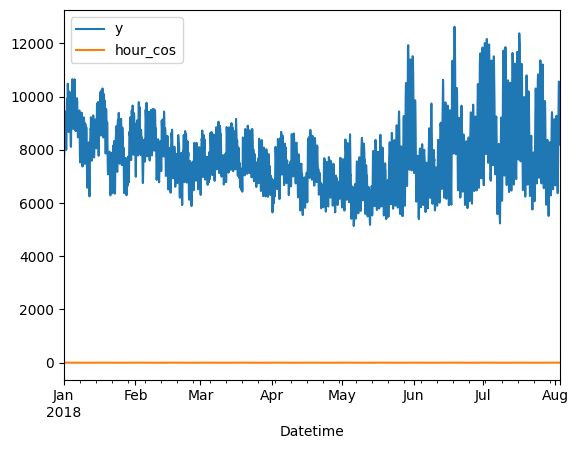

In [30]:
df[['y', 'hour_cos']].loc['2018'].plot()
plt.show()

In [31]:
def model_assessment(train, test, prediction, title):
    plt.figure(figsize=(10, 5))

    plt.plot(train, label='train')
    plt.plot(test, label='test')

    plt.plot(prediction, label='Forecast')

    plt.legend()
    plt.title(f"Train, test and forcase of {title}")
    plt.show()

    mae = mean_absolute_error(test, prediction)
    rmse = root_mean_squared_error(test, prediction)
    mape = mean_absolute_percentage_error(test, prediction)

    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {100 * mape:.2f}%")

#Train and Test


In [32]:
# last 24hrs
periods = 100
train, test = df.iloc[:-periods], df.iloc[-periods:]
print("Training data", train.shape)
print("Testing data", test.shape)

Training data (62612, 20)
Testing data (100, 20)


In [33]:
target_col = 'y'
feature_col = [col for col in train.columns if col != target_col]

In [35]:
X_train = train[feature_col]
X_test = test[feature_col]

Y_train = train[target_col]
Y_test = test[target_col]

## 1. LightGBM

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62712 entries, 2011-06-08 01:00:00 to 2018-08-03 00:00:00
Freq: h
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   y                  62712 non-null  float64
 1   lag_1h             62712 non-null  float64
 2   lag_2h             62712 non-null  float64
 3   lag_3h             62712 non-null  float64
 4   lag_24h            62712 non-null  float64
 5   lag_48h            62712 non-null  float64
 6   lag_168h           62712 non-null  float64
 7   rolling_mean_24h   62712 non-null  float64
 8   rolling_mean_168h  62712 non-null  float64
 9   year               62712 non-null  int32  
 10  month              62712 non-null  int32  
 11  day                62712 non-null  int32  
 12  hour               62712 non-null  int32  
 13  weekday_numeric    62712 non-null  int32  
 14  is_weekend         62712 non-null  bool   
 15  is_peak_hour       62712 no

In [37]:
params = {
    "objective": "regression",
    "metric": "mae",
    "learning_rate": 0.05,
    "num_leaves":31,
    "verbose": -1
}

lgb_train_data = lgb.Dataset(X_train, label=Y_train)
lgb_model = lgb.train(params, lgb_train_data, num_boost_round=500)

In [38]:
pred_lgb = lgb_model.predict(X_test)

mae = mean_absolute_error(Y_test, pred_lgb)
rmse = root_mean_squared_error(Y_test, pred_lgb)
mape = mean_absolute_percentage_error(Y_test, pred_lgb)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {100 * mape:.2f}%")


MAE: 64.01
RMSE: 83.27
MAPE: 0.76%


In [40]:
joblib.dump(lgb_model, '../output/energy_model_lightgbm.pkl')

['energy_model_lightgbm.pkl']

2. LSTM (Long short term memory)

In [ ]:
def prepare_lstm_data(target, sequence_length=168, horizon=24):
    """
    Create sequence for LSTM model
    :param target: target column
    :param sequence_length: last week (168 hrs)
    :param horizon: last 24 hrs
    :return:
    """


    data = target.values

    x, y = [], []

    for i in range(0, len(data) - sequence_length - horizon + 1):
        x.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length: i + sequence_length + horizon])

    return np.array(x), np.array(y)


In [ ]:
sequence_length=168
horizon=24
x_lstm, y_lstm = prepare_lstm_data(df['y'], sequence_length, horizon)

# Reshape for lstm
x_lstm = x_lstm.reshape(x_lstm.shape[0], x_lstm.shape[1], 1)

In [ ]:
train_size = len(x_lstm) - 1
X_train_lstm = x_lstm[:train_size]
X_test_lstm = y_lstm[train_size:]

Y_train_lstm = y_lstm[:train_size]
Y_test_lstm = y_lstm[train_size:]

In [ ]:
scaler = StandardScaler()

In [ ]:
X_train_lstm_scaled = scaler.fit_transform(X_train_lstm.reshape(-1, 1)).reshape(X_train_lstm.shape)
X_test_lstm_scaled = scaler.fit_transform(X_test_lstm.reshape(-1, 1)).reshape(X_test_lstm.shape)

In [ ]:
# create and train lstm
lstm_model = keras.Sequential([
    layers.LSTM(64, activation='tanh', return_sequences=True, input_shape=(sequence_length, 1)),
    layers.Dropout(0.2),
    layers.LSTM(32, activation='tanh'),
    layers.Dropout(0.2),
    layers.Dense(horizon)
])

lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = lstm_model.fit(
    X_train_lstm_scaled,
    Y_train_lstm,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
)

y_predict_lstm = lstm_model.predict(X_test_lstm_scaled)[0]


In [ ]:
mae_lstm = mean_absolute_error(Y_test_lstm[0], y_predict_lstm)
rmse_lstm = root_mean_squared_error(Y_test_lstm[0], y_predict_lstm)
mape_lstm = mean_absolute_percentage_error(Y_test_lstm[0], y_predict_lstm)

print(f"MAE: {mae_lstm:.2f}")
print(f"RMSE: {rmse_lstm:.2f}")
print(f"MAPE: {100 * mape_lstm:.2f}%")

# 3. Cat Boost

In [ ]:
def train_catboost(X_train, X_test, Y_train, Y_test, cat_features):

    X_train_copy = X_train.copy()
    X_test_copy = X_test.copy()

    for col in cat_features:
        X_train_copy[col] = X_train_copy[col].astype(str)
        X_test_copy[col] = X_test_copy[col].astype(str)

    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        loss_function='MAE',
        cat_features=cat_features,
        early_stopping_rounds=50,
        verbose=100
    )

    model.fit(
        X_train_copy,
        Y_train,
        eval_set=(X_test_copy, Y_test),
        use_best_model=True
    )

    cat_predictions = model.predict(X_test_copy)
    MAE = mean_absolute_error(Y_test, cat_predictions)
    RMSE = root_mean_squared_error(Y_test, cat_predictions)
    MAPE = mean_absolute_percentage_error(Y_test, cat_predictions)

    print(f"MAE: {MAE:.2f}")
    print(f"RMSE: {RMSE:.2f}")
    print(f"MAPE: {100 * MAPE:.2f}%")

    return model

In [ ]:
cat_model = train_catboost(X_train, X_test, Y_train, Y_test, feature_col)